# **1. SETI Space Signal Classification**

### **1. Setup of enviroment and loading the dataset**

In [17]:
# Library imports
import os
import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from Custom_plots import PlotConfusionMatrix
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, CSVLogger, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.metrics import categorical_accuracy


# Set-up CUDA enviroment
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# This sets the GPU to allocate memory only as needed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 

In [2]:
# Define the directories for the training, validation and testing dataset
base_directory = './primary_small/'
train_directory = os.path.join(base_directory, 'train')
val_directory = os.path.join(base_directory, 'valid')
test_directory = os.path.join(base_directory, 'test')

# Get the labels from the training directory
classes_list = sorted(os.listdir(train_directory))
classes_list

['brightpixel',
 'narrowband',
 'narrowbanddrd',
 'noise',
 'squarepulsednarrowband',
 'squiggle',
 'squigglesquarepulsednarrowband']

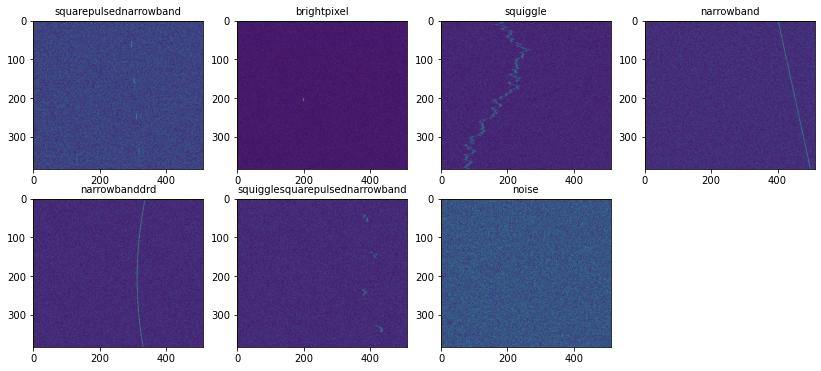

In [3]:
# Set training batch size
batch_size= 32

# Read the training images from directory for plot
data_signal_files = glob.glob(train_directory+'/*/*.png')
sample_files = [data_signal_files[idx] for idx in range(0,5600,800+15)]
fix, ax = plt.subplots(2,4,figsize=(14,6))

for idx, img in enumerate(sample_files):
    id1 = 1 if idx > 3 else 0
    id2 = idx % 4
    img_arr = img_to_array(load_img(img))
    f = ax[id1, id2].imshow(img_arr / 255., aspect='auto')
    t = ax[id1, id2].set_title(img.split('/')[-1].split('.')[0].split('_')[-1], fontsize=10)
ax[1,3].set_axis_off()

In [4]:
# Define data augmentation: normalize values to interval [0,1] for all sets, perform rotation, zooming, flips and filling for training set
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.05, rotation_range=180, vertical_flip=True,
                                  horizontal_flip=True, fill_mode='reflect')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
img_dim = (192, 192)
# Read the images and perform  data augmentation
train_generator = train_datagen.flow_from_directory(directory=train_directory, classes=classes_list, target_size=img_dim, 
                                                    batch_size=batch_size, class_mode='categorical', interpolation='bicubic',
                                                   shuffle=True, seed=42)

val_generator = valid_datagen.flow_from_directory(directory=val_directory, classes = classes_list, target_size=img_dim, batch_size=batch_size,
                                                 class_mode='categorical', shuffle=False, seed=42, interpolation='bicubic')

Found 5600 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


### **2. Creating the model**

In [6]:
input_shape = (192, 192, 3)
num_output = len(classes_list)
# Import pretrained ResNet50 model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
# Make layers trainable
base_model.trainable = True
for layer in base_model.layers:
    base_model.trainable = True

2022-03-31 20:48:41.745321: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-31 20:48:41.745833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 20:48:41.746067: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 7.77GiB deviceMemoryBandwidth: 462.00GiB/s
2022-03-31 20:48:41.746088: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic libra

In [7]:
# Include the custom final layers
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x) # 1st dense layer
x = Dropout(rate=0.2)(x) # Regularization
x = Dense(512, activation='relu')(x) # 2nd dense layer
x = Dropout(rate=0.2)(x) # Regularization

out = Dense(num_output, activation='softmax')(x) # Output layer

model = Model(inputs = base_model.input, outputs=out)

# Use categorical (one-hot labels) accuracy
model.compile(optimizer=RMSprop(lr=1e-5), loss='categorical_crossentropy', metrics=[categorical_accuracy])

In [8]:
csv_logger = CSVLogger('training_info.csv', append=True)

history = model.fit(train_generator, epochs = 50, 
                              validation_data=val_generator, callbacks=[csv_logger], verbose=1)

2022-03-31 20:48:46.193951: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-31 20:48:46.213963: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz


Epoch 1/50


2022-03-31 20:48:51.462858: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-31 20:48:51.735279: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-03-31 20:48:52.256872: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-03-31 20:48:52.299600: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-03-31 20:49:00.184242: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-31 20:4

175/175 [==============================] - ETA: 0s - loss: 1.8794 - categorical_accuracy: 0.3878

2022-03-31 20:50:19.883843: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


175/175 [==============================] - 94s 381ms/step - loss: 1.8776 - categorical_accuracy: 0.3883 - val_loss: 40.8391 - val_categorical_accuracy: 0.1429


2022-03-31 20:50:20.505945: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


Epoch 2/50
175/175 [==============================] - 56s 322ms/step - loss: 1.1803 - categorical_accuracy: 0.5744 - val_loss: 89.1275 - val_categorical_accuracy: 0.1429
Epoch 3/50
175/175 [==============================] - 56s 321ms/step - loss: 1.0052 - categorical_accuracy: 0.6493 - val_loss: 87.0559 - val_categorical_accuracy: 0.1429
Epoch 4/50
175/175 [==============================] - 56s 321ms/step - loss: 0.8919 - categorical_accuracy: 0.6769 - val_loss: 70.9413 - val_categorical_accuracy: 0.1429
Epoch 5/50
175/175 [==============================] - 56s 321ms/step - loss: 0.8122 - categorical_accuracy: 0.7221 - val_loss: 58.9117 - val_categorical_accuracy: 0.1429
Epoch 6/50
175/175 [==============================] - 56s 319ms/step - loss: 0.7939 - categorical_accuracy: 0.7271 - val_loss: 20.4182 - val_categorical_accuracy: 0.1500
Epoch 7/50
175/175 [==============================] - 56s 320ms/step - loss: 0.7632 - categorical_accuracy: 0.7389 - val_loss: 5.0576 - val_categorica

In [14]:
#model.summary(100)
#plot_model(model, show_shapes=True, show_layer_names=False)

### **3. Evaluate Performace**

In [15]:
test_generator = test_datagen.flow_from_directory(directory=test_directory, classes=classes_list, target_size=img_dim, batch_size=1,
                                                 class_mode='categorical', interpolation='bicubic', shuffle=False, seed=42)

class_label_mapping = {v:k for k,v in test_generator.class_indices.items()}
test_data = [next(test_generator) for i in range(700)]
test_data_X = [data[0] for data in test_data]
test_data_X = np.array(np.squeeze(test_data_X, axis=1))
test_data_y = np.array([fname.split('/')[0] for fname in test_generator.filenames])
class_labels = list(set(test_data_y))

test_data_X.shape, test_data_y.shape

Found 700 images belonging to 7 classes.


((700, 192, 192, 3), (700,))

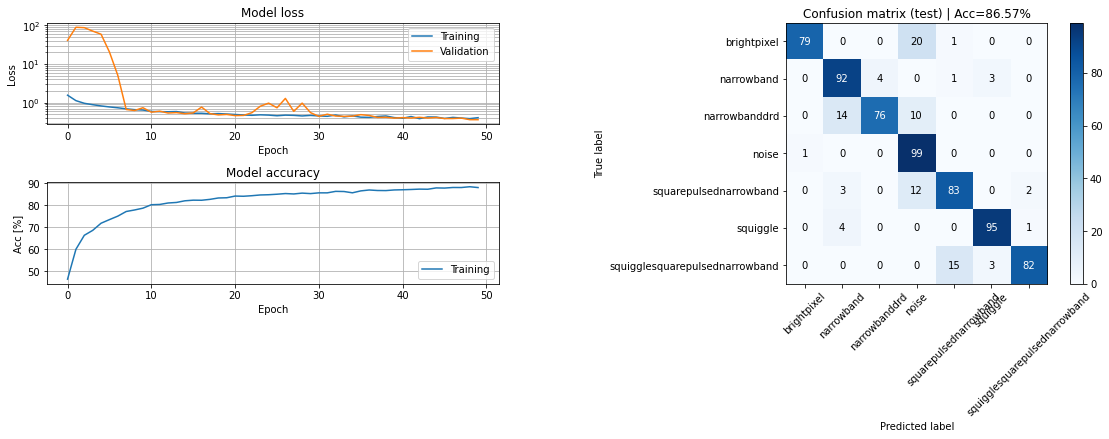

In [18]:
PlotModelEval(Model = model, History = history, 
              X = test_data_X, Y = test_data_y, Labels = classes_list, Label_Mapping = class_label_mapping)


## References

Dataset:
https://www.kaggle.com/datasets/tentotheminus9/seti-data


Code chucks:

https://www.kaggle.com/code/ahmed103/radio-signal-classification-keras-cnn


https://www.kaggle.com/code/sahilchachra/2nd-wow-signal-resnet-50
